In [24]:

from src.components.nn_data_ingestion import FraudDetectionDataset,SequentialFraudDetectionDataset,BaggingSequentialFraudDetectionDataset
from src.components.data_ingestion import DataIngestorFactory, DataIngestorConfig
from torch.utils.data import DataLoader
from src.components.features_engineering import PreprocessorPipeline
import pandas as pd
import os
import torch

from src.models.bagging_cnn_ffnn import BaggingCNN_FFNN

In [28]:

os.chdir(rf"c:\Users\thuhi\workspace\fraud_detection")
print(os.getcwd())
batch_size = 512
epoch = 20
patience = 5
pos_mul = 3
hidden_size = 128
start_date = "2018-04-01"
end_train_date = "2018-12-31"
start_test_date = "2018-08-01"
end_test_date = "2018-10-01"
c_seq_len = 7
t_seq_len = 7
embedding_dim=16        # NEW Hyperparameter: A good starting point. Tune this (e.g., 8, 16, 32).
cnn_out_channels=128      # Number of patterns to learn.
cnn_kernel_size=3        # Size of the pattern window.
expert_hidden_size=512    
accumulate_grad_batches=1
fast_dev_run=False
config = DataIngestorConfig()

factory = DataIngestorFactory()
ingestor = factory.create_ingestor("duration_pkl")
train_df, _ = ingestor.ingest(
    dir_path=rf"C:\Users\thuhi\workspace\fraud_detection\data\transformed_upsampled_data",
    start_train_date=start_date,
    end_train_date= end_train_date,
    end_test_date= end_test_date,
    start_test_date= start_test_date)
_, validation_df = ingestor.ingest(
    dir_path=rf"C:\Users\thuhi\workspace\fraud_detection\data\transformed_data",
    start_train_date=start_date,
    end_train_date= end_train_date,
    end_test_date= end_test_date,
    start_test_date= start_test_date)
train_df =train_df.sort_values("TX_DATETIME").reset_index(drop=True)
validation_df =validation_df.sort_values("TX_DATETIME").reset_index(drop=True)





c:\Users\thuhi\workspace\fraud_detection
2025-07-01 16:25:56,149 - INFO - Train: 2018-04-01 - 2018-12-31
2025-07-01 16:25:58,814 - INFO - Test: 2018-08-01 - 2018-10-01
2025-07-01 16:25:58,885 - INFO - Train: 2018-04-01 - 2018-12-31
2025-07-01 16:25:59,303 - INFO - Test: 2018-08-01 - 2018-10-01


In [30]:
pos_weight = pos_mul * 1/torch.tensor(train_df[DataIngestorConfig().output_feature].sum()
                              / (len(train_df) - train_df[DataIngestorConfig().output_feature].sum()))

                            # Load model from checkpoint
check_point =rf"C:\Users\thuhi\workspace\fraud_detection\fraud_detection_api\artifacts\fraud_model.ckpt"
model = BaggingCNN_FFNN.load_from_checkpoint(

    checkpoint_path=check_point,
    current_tx_feature_size=len(config.input_features_transformed),
    embedding_dim=embedding_dim,          # NEW Hyperparameter: A good starting point. Tune this (e.g., 8, 16, 32).
    cnn_out_channels=cnn_out_channels,      # Number of patterns to learn.
    cnn_kernel_size=cnn_kernel_size,         # Size of the pattern window.
    expert_hidden_size=expert_hidden_size,    # Size of the expert networks.
    pos_weight=float(pos_weight),
    learning_rate=1e-3
) 


In [31]:

validation_preprocessed = PreprocessorPipeline(validation_df,add_method=["scale"]).process()
train_preprocessed = PreprocessorPipeline(train_df,add_method=["scale"]).process()

train_data = BaggingSequentialFraudDetectionDataset(train_preprocessed, t_seq_len= t_seq_len,c_seq_len=c_seq_len,mode="target")
validation_data = BaggingSequentialFraudDetectionDataset(validation_preprocessed, t_seq_len= t_seq_len,c_seq_len=c_seq_len,mode="target")
    
batch_size = 512

validation_loader = DataLoader(
    validation_data,
    batch_size=batch_size,
    num_workers=8,
    persistent_workers=True,
    shuffle=False,
    pin_memory= True,
    prefetch_factor=6

)

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    num_workers=8,
    persistent_workers=True,
    shuffle=False,
    pin_memory= True,
    prefetch_factor=6)

2025-07-01 16:28:15,408 - INFO - BaggingSequentialDataset initialized successfully.
2025-07-01 16:28:15,828 - INFO - BaggingSequentialDataset initialized successfully.


     AUCROC       F1  Top100k_Precision
0  0.957815  0.65615               0.83
Middle range samples: 584432


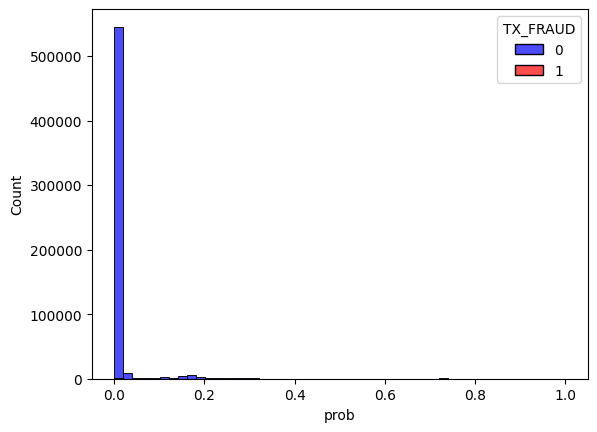

In [32]:

# Normalize if needed (replace with your training mean/std)
# mean = torch.tensor(train_mean)
# std = torch.tensor(train_std)
# test_data = (test_data - mean) / std

# Load the model

model.eval()
all_probs = []
all_preds = []

with torch.no_grad():
    for batch in validation_loader:
        # If your dataset returns (X, y), unpack it
        if isinstance(batch, (tuple, list)):
            X = batch[0]
        else:
            X = batch
        # If X is a list of tensors, move each to device
        if isinstance(X, list):
            X = [x.to(model.device) for x in X]
        else:
            X = X.to(model.device)
        y_hat = model(X)
        y_prob = torch.sigmoid(y_hat).squeeze(-1)
        y_pred = (y_prob > 0.5).float()
        all_probs.append(y_prob.cpu())
        all_preds.append(y_pred.cpu())

# Concatenate all predictions
import torch
y_prob = torch.cat(all_probs)
y_pred = torch.cat(all_preds)

predicted_proba = pd.DataFrame(y_prob.cpu())
validation_preprocessed.reset_index(drop=True,inplace=True)
validation_preprocessed["prob"] = predicted_proba
validation_preprocessed["TX_FRAUD"].value_counts()
import seaborn as sns
from sklearn.metrics import roc_auc_score, f1_score, precision_score

# AUC-ROC
y_true = validation_preprocessed["TX_FRAUD"].values
y_scores = validation_preprocessed["prob"].values

aucroc = roc_auc_score(y_true, y_scores)

# F1 score at threshold 0.5
y_pred_bin = (y_scores > 0.3).astype(int)
f1 = f1_score(y_true, y_pred_bin)

# Top 100k precision
top_k = 1000                                                                                                                                                                                                                                                                                                                                                                
top_k_idx = y_scores.argsort()[-top_k:][::-1]
precision_top_k = precision_score(y_true[top_k_idx], y_pred_bin[top_k_idx])

# Report as DataFrame
metrics_df = pd.DataFrame({
    "AUCROC": [aucroc],
    "F1": [f1],
    "Top100k_Precision": [precision_top_k]
})
print(metrics_df)
print(f"Middle range samples: {len(validation_preprocessed)}")

filtered_df = validation_preprocessed
if not filtered_df.empty:
    sns.histplot(
        data=filtered_df,
        x="prob",                              
        hue="TX_FRAUD",
        multiple="stack",
        bins=50,
        palette={0: "blue", 1: "red"},
        alpha=0.7
    )
else:
    print("No samples with prob >= 0.5 to plot.")


2025-07-01 16:28:33,838 - INFO - BaggingSequentialDataset initialized successfully.


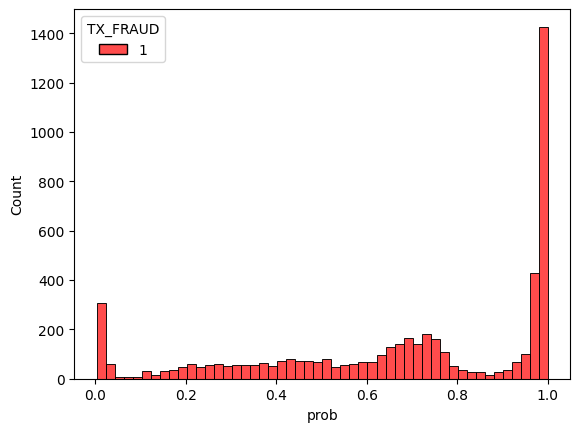

In [33]:

# Normalize if needed (replace with your training mean/std)
# mean = torch.tensor(train_mean)
# std = torch.tensor(train_std)
# test_data = (test_data - mean) / std

# Load the model
validation_preprocessed_fraud = validation_preprocessed[validation_preprocessed["TX_FRAUD"]==1]
validation_data = BaggingSequentialFraudDetectionDataset(validation_preprocessed_fraud, t_seq_len= t_seq_len,c_seq_len=c_seq_len,mode="target")
    
batch_size = 512

validation_loader = DataLoader(
    validation_data,
    batch_size=batch_size,
    num_workers=8,
    persistent_workers=True,
    shuffle=False,
    pin_memory= True,
    prefetch_factor=6

)
model.eval()
all_probs = []
all_preds = []

with torch.no_grad():
    for batch in validation_loader:
        # If your dataset returns (X, y), unpack it
        if isinstance(batch, (tuple, list)):
            X = batch[0]
        else:
            X = batch
        # If X is a list of tensors, move each to device
        if isinstance(X, list):
            X = [x.to(model.device) for x in X]
        else:
            X = X.to(model.device)
        y_hat = model(X)
        y_prob = torch.sigmoid(y_hat).squeeze(-1)
        y_pred = (y_prob > 0.5).float()
        all_probs.append(y_prob.cpu())
        all_preds.append(y_pred.cpu())

# Concatenate all predictions
import torch
y_prob = torch.cat(all_probs)
y_pred = torch.cat(all_preds)

predicted_proba = pd.DataFrame(y_prob.cpu())
validation_preprocessed_fraud.reset_index(drop=True,inplace=True)
validation_preprocessed_fraud["prob"] = predicted_proba
validation_preprocessed_fraud["TX_FRAUD"].value_counts()
import seaborn as sns
from sklearn.metrics import roc_auc_score, f1_score, precision_score



# F1 score at threshold 0.5
y_pred_bin = (y_scores > 0.5).astype(int)
f1 = f1_score(y_true, y_pred_bin)

# Top 100k precision
top_k = 1000                                                                                                                                                                                                                                                                                                                                                                
top_k_idx = y_scores.argsort()[-top_k:][::-1]
precision_top_k = precision_score(y_true[top_k_idx], y_pred_bin[top_k_idx])

filtered_df = validation_preprocessed_fraud
if not filtered_df.empty:
    sns.histplot(
        data=filtered_df,
        x="prob",
        hue="TX_FRAUD",
        multiple="stack",
        bins=50,
        palette={0: "blue", 1: "red"},
        alpha=0.7
    )
else:
    print("No samples with prob >= 0.5 to plot.")


In [34]:
import torch
import numpy as np # Import numpy for formatting the printout

def debug_forward_gating(model, x):
    """
    Performs a forward pass for the GATING-based model and prints the logits
    and gating weights from each component.
    """
    customer_history, terminal_history, current_tx = x

    # --- 1. Get Embeddings and Individual Expert Logits (as before) ---
    cust_embedded = model.customer_embedding(customer_history).permute(0, 2, 1)
    cust_cnn_out = model.customer_cnn(cust_embedded)
    customer_logit = model.customer_expert(cust_cnn_out)

    term_embedded = model.terminal_embedding(terminal_history).permute(0, 2, 1)
    term_cnn_out = model.terminal_cnn(term_embedded)
    terminal_logit = model.terminal_expert(term_cnn_out)
    
    current_tx_logit = model.current_tx_expert(current_tx)


    # --- 3. Calculate the Final Logit using the Gating Weights ---
    
    # Concatenate the 'opinions' (the logits)
    expert_logits = torch.cat([customer_logit, terminal_logit, current_tx_logit], dim=1)
    
    # Calculate the final logit as a weighted sum of the expert opinions
    final_logits = model.meta_combiner(expert_logits)
    
    # --- 4. Calculate Probabilities for Reporting ---
    final_prob = torch.sigmoid(final_logits)
    cust_prob = torch.sigmoid(customer_logit)
    term_prob = torch.sigmoid(terminal_logit)
    tx_prob = torch.sigmoid(current_tx_logit)

    # --- 5. Print Enhanced Report ---
    print("--- DEBUGGING GATING MODEL INTERNALS ---")

    print("---------------------------------")
    print(f"Customer History -> Logit: {customer_logit.item():.4f} | Prob: {cust_prob.item():.4f}")
    print(f"Terminal History -> Logit: {terminal_logit.item():.4f} | Prob: {term_prob.item():.4f}")
    print(f"Current TX       -> Logit: {current_tx_logit.item():.4f} | Prob: {tx_prob.item():.4f}")
    print("---------------------------------")
    print(f"Final Combined Logit: {final_logits.item():.4f}")
    print(f"Final Fraud Probability: {final_prob.item():.4f}")


def debug_single_sample(model, dataset, index: int):
    """
    Selects a single sample from a dataset by index, formats it correctly,
    and runs it through the debug_forward_gating function.
    (This function does not need significant changes, only the call at the end)
    """
    print(f"=========================================")
    print(f"    ANALYZING SAMPLE AT INDEX: {index}    ")
    print(f"=========================================")

    # Get sample and true label (unchanged)
    sample_inputs, sample_target = dataset[index]
    try:
        true_label = sample_target[2].item()
    except (TypeError, IndexError):
        true_label = sample_target.item()
    print(f"Ground Truth Label: {true_label}")
    print("---------------------------------")

    # Unpack inputs (unchanged)
    cust_hist, term_hist, curr_tx = sample_inputs
    
    # Prepare input for the model (unchanged)
    model_device = next(model.parameters()).device
    batched_input = (
        cust_hist.unsqueeze(0).long().to(model_device),
        term_hist.unsqueeze(0).long().to(model_device),
        curr_tx.unsqueeze(0).to(model_device)
    )

    # Run the NEW debugging function in no_grad mode
    with torch.no_grad():
        debug_forward_gating(model, batched_input)
    print("\n")

# --- EXAMPLE USAGE ---
# This would go in your main inference/analysis script

# 1. Load your GATING model and dataset
# model = BaggingCNN_FFNN.load_from_checkpoint("path/to/your/gating_model.ckpt")
# validation_data = YourDataset(...)

# 2. Set the model to evaluation mode
# model.eval()

# 3. Pick an index and debug
# index_to_check = 50
# debug_single_sample(model, validation_data, index_to_check)

In [35]:
from torch.utils.data import Dataset
import numpy as np
class BaggingSequentialDataset(Dataset):
    def __init__(self, df: pd.DataFrame, c_seq_len=5,t_seq_len=5,mode=None):

        self.mode =mode
        self.config = DataIngestorConfig()
        
        self.t_historical_len = t_seq_len - 1
        self.c_historical_len = c_seq_len - 1
        self.df_source = df.copy().sort_values("TX_DATETIME").reset_index(drop=True)
        self.num_samples = len(self.df_source)

        # --- 1. Prepare Target and Current Transaction Features ---
        self.targets = torch.tensor(self.df_source[self.config.output_feature].values, dtype=torch.int8)
        target_padding = torch.zeros(1, dtype=torch.float32)
        self.targets = torch.hstack([self.targets, target_padding])
        # The "current" stream gets all transformed features
        self.current_tx_features = torch.tensor(self.df_source[self.config.input_features_transformed].values, dtype=torch.float32)

        # --- 2. Prepare Customer History Stream ---
        customer_features_tensor = torch.tensor(self.df_source[self.config.input_features_customer].values, dtype=torch.float32)
        cust_padding = torch.zeros(1, customer_features_tensor.shape[1], dtype=torch.float32)
        self.customer_features_pool = torch.vstack([customer_features_tensor, cust_padding])
        cust_padding_idx = len(self.customer_features_pool) - 1

        # --- 3. Prepare Terminal History Stream ---
        terminal_features_tensor = torch.tensor(self.df_source[self.config.input_features_terminal].values, dtype=torch.float32)
        term_padding = torch.zeros(1, terminal_features_tensor.shape[1], dtype=torch.float32)
        self.terminal_features_pool = torch.vstack([terminal_features_tensor, term_padding])
        term_padding_idx = len(self.terminal_features_pool) - 1

        # --- 4. Create Index Mappings for Both History Types ---
        df_for_indices = pd.DataFrame({
            'CUSTOMER_ID': self.df_source['CUSTOMER_ID'],
            'TERMINAL_ID': self.df_source['TERMINAL_ID'],
            'tmp_idx': np.arange(self.num_samples)
        })

        # Customer history indices (looks back 1 to `historical_len` steps)
        cust_groupby = df_for_indices.groupby('CUSTOMER_ID')
        cust_sequences = {f"tx_{i}": cust_groupby['tmp_idx'].shift(i) for i in range(1, self.c_historical_len + 1)}
        self.customer_indices = torch.tensor(pd.DataFrame(cust_sequences).fillna(cust_padding_idx).values, dtype=torch.long)
        
        # Terminal history indices (looks back 1 to `historical_len` steps)
        term_groupby = df_for_indices.groupby('TERMINAL_ID')
        term_sequences = {f"tx_{i}": term_groupby['tmp_idx'].shift(i) for i in range(1, self.t_historical_len + 1)}
        self.terminal_indices = torch.tensor(pd.DataFrame(term_sequences).fillna(term_padding_idx).values, dtype=torch.long)


    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        # --- Assemble Customer History ---
        cust_hist_indices = self.customer_indices[index]
        customer_history_seq = self.customer_features_pool[cust_hist_indices]

        # --- Assemble Terminal History ---
        term_hist_indices = self.terminal_indices[index]
        terminal_history_seq = self.terminal_features_pool[term_hist_indices]

        # --- Get Current Transaction Info ---
        current_tx = self.current_tx_features[index]

        # --- Get Target Label ---
        target = self.targets[index]
        if not self.mode:
            return (customer_history_seq, terminal_history_seq, current_tx), target
        if self.mode =="eda":
            return  (self.targets[cust_hist_indices],self.targets[term_hist_indices],self.targets[index])
      
validation = BaggingSequentialDataset(df = validation_df,mode="eda",c_seq_len=7,t_seq_len=14)

In [36]:
validation_data = BaggingSequentialFraudDetectionDataset(validation_preprocessed, t_seq_len= t_seq_len,c_seq_len=c_seq_len,mode="target")
df1 =validation_preprocessed[(validation_preprocessed["prob"]>=0.5) &(validation_preprocessed["prob"]<=1) &(validation_preprocessed["TX_FRAUD"]==1)].sort_values(["CUSTOMER_ID","TX_DATETIME"])
df_source = validation.df_source
cols = [
    "TRANSACTION_ID", "TX_DATETIME", "CUSTOMER_ID", "TERMINAL_ID",
    "TX_AMOUNT", "TX_TIME_SECONDS", "TX_TIME_DAYS",
    "TX_FRAUD", "TX_FRAUD_SCENARIO", "prob"
]



2025-07-01 16:28:40,536 - INFO - BaggingSequentialDataset initialized successfully.


In [37]:
# --- EXAMPLE USAGE ---
# This would go in your main inference/analysis script

# 2. Set the model to evaluation mode (very important!)
model.eval()

# 3. Pick an index to inspect and run the debug function
index_to_check = 206217							# Choose any index from your validation set
debug_single_sample(model, validation_data, index_to_check)
validation[index_to_check]
# You can even loop through a few interesting indices
# for i in [100, 500, 1234, 5678]:
#     debug_single_sample(model, validation_data, i)

    ANALYZING SAMPLE AT INDEX: 206217    
Ground Truth Label: 1
---------------------------------


AttributeError: 'BaggingCNN_FFNN' object has no attribute 'meta_combiner'

In [ ]:
def debug_forward_gating(model, x):
    """
    Performs a forward pass for the GATING-based model and prints the logits
    and gating weights from each component.
    """
    customer_history, terminal_history, current_tx = x

    # --- 1. Get Embeddings and Individual Expert Logits ---
    cust_embedded = model.customer_embedding(customer_history).permute(0, 2, 1)
    cust_cnn_out = model.customer_cnn(cust_embedded)
    customer_logit = model.customer_expert(cust_cnn_out)

    term_embedded = model.terminal_embedding(terminal_history).permute(0, 2, 1)
    term_cnn_out = model.terminal_cnn(term_embedded)
    terminal_logit = model.terminal_expert(term_cnn_out)
    
    current_tx_logit = model.current_tx_expert(current_tx)

    expert_logits = torch.cat([customer_logit, terminal_logit, current_tx_logit], dim=1)
    final_logits = model.meta_combiner(expert_logits)
    
    # --- 4. Calculate Probabilities ---
    final_prob = torch.sigmoid(final_logits)
    cust_prob = torch.sigmoid(customer_logit)
    term_prob = torch.sigmoid(terminal_logit)
    tx_prob = torch.sigmoid(current_tx_logit)

    # --- 5. Print Report ---
    print("--- DEBUGGING GATING MODEL INTERNALS ---")

    print("---------------------------------")
    print(f"Customer History -> Logit: {customer_logit.item():.4f} | Prob: {cust_prob.item():.4f}")
    print(f"Terminal History -> Logit: {terminal_logit.item():.4f} | Prob: {term_prob.item():.4f}")
    print(f"Current TX       -> Logit: {current_tx_logit.item():.4f} | Prob: {tx_prob.item():.4f}")
    print("---------------------------------")
    print(f"Final Combined Logit: {final_logits.item():.4f}")
    print(f"Final Fraud Probability: {final_prob.item():.4f}")


def test_model_manually(model, c_seq_len: int, t_seq_len: int, current_tx_feature_size: int,
                        customer_history=None, terminal_history=None, current_tx=None):
    """
    Allows manual testing of the model with Python lists as input.
    Handles padding, tensor conversion, and batching.
    """
    # Set the model to evaluation mode (disables dropout, etc.)
    model.eval()
    model_device = next(model.parameters()).device

    # --- 1. Process Customer History ---
    if customer_history is None:
        customer_history = [0] * c_seq_len # Default to a clean history
    # Pad the sequence if it's shorter than required
    num_pads = c_seq_len - len(customer_history)
    if num_pads < 0:
        raise ValueError(f"Customer history is too long! Max is {c_seq_len}")
    padded_cust_hist = ([0] * num_pads) + customer_history
    cust_tensor = torch.tensor(padded_cust_hist, dtype=torch.long)

    # --- 2. Process Terminal History ---
    if terminal_history is None:
        terminal_history = [0] * t_seq_len # Default to a clean history
    num_pads = t_seq_len - len(terminal_history)
    if num_pads < 0:
        raise ValueError(f"Terminal history is too long! Max is {t_seq_len}")
    padded_term_hist = ([0] * num_pads) + terminal_history
    term_tensor = torch.tensor(padded_term_hist, dtype=torch.long)

    # --- 3. Process Current Transaction ---
    if current_tx is None:
        # Default to a "neutral" transaction of all zeros
        current_tx = [0.0] * current_tx_feature_size 
    if len(current_tx) != current_tx_feature_size:
        raise ValueError(f"current_tx must have {current_tx_feature_size} features.")
    tx_tensor = torch.tensor(current_tx, dtype=torch.float)

    # --- 4. Create a Batch of Size 1 and Run Inference ---
    batched_input = (
        cust_tensor.unsqueeze(0).to(model_device),
        term_tensor.unsqueeze(0).to(model_device),
        tx_tensor.unsqueeze(0).to(model_device)
    )

    print(f"Customer Seq Input: {padded_cust_hist}")
    print(f"Terminal Seq Input: {padded_term_hist}")
    
    with torch.no_grad():
        debug_forward_gating(model, batched_input)
    print("\n" + "="*40 + "\n")




In [ ]:
C_SEQ_LEN = 7
T_SEQ_LEN = 7
CURRENT_TX_FEATURES = 15
test_model_manually(model, C_SEQ_LEN, T_SEQ_LEN, CURRENT_TX_FEATURES,
                    customer_history=[0, 0, 0, 0, 0, 0,1],
                    terminal_history=[1, 1, 1, 0, 0, 0, 0],
                    current_tx = [3.8367e-02, 1.0000e+00, 0.0000e+00, 7.3180e-04, 3.7373e-02, 1.0241e-02,
          7.6325e-02, 3.5845e-02, 9.5851e-02, 1.2500e-01, 0.0000e+00, 5.0000e-01,
          0.0000e+00, 3.8462e-01, 0.0000e+00])

Customer Seq Input: [0, 0, 0, 0, 0, 0, 1]
Terminal Seq Input: [1, 1, 1, 0, 0, 0, 0]
--- DEBUGGING GATING MODEL INTERNALS ---
---------------------------------
Customer History -> Logit: 5.1376 | Prob: 0.9942
Terminal History -> Logit: -3.9763 | Prob: 0.0184
Current TX       -> Logit: 3.1337 | Prob: 0.9583
---------------------------------
Final Combined Logit: -0.5201
Final Fraud Probability: 0.3728


